__Project description__:
The following project was worked on by me and my friend, Bernard Wong. We used pandas, geopandas and learnt how to anlayse spatial structures through this project. The project focused on the analysis of food deserts

In [0]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd

# add packages as needed
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

--------------------------------------------------------------------------------------

Food choices in low and medium income (LMI) neighborhoods are limited, as these areas lack healthy food stores or other fresh food delivery mechanisms. There may be more fast food stores than fresh produce shops. Population is relatively poor, and filling the food basket with healthy options hasn't been an overwhelming priority for many households. Such areas are referred to as "food deserts". 

We'll analyze the current state of food deserts, using lists of businesses that operate in San Diego, and social-demographic data from SanDAG (by census tracts). 

The steps we took to analyse the state of food deserts are:

1. We downloaded the data - promise zone, census tracts, jurisdictions, read them into geopandas dataframes, and merged social-demographic data with tract boundaries as needed.

2. We subsetted the businesses.

3. Determined census tracts intersecting with the promise zone, and all other census tracts within the boundary of San Diego.

4. For each census tract marked as belonging to the promise zone, and the other tracts within the city limits, we calculated the number of healthy and not-healthy options within that tract. 

5. We computed the ratio of healthy and non-healthy options, and built a regression model showing how it depends on social-demographic characteristics, such as median income or number of people in lowest and highest income brackets.

6. We generated a map showing the ratio of healthy and not healthy food options, and the locations of stores offering healthy food options. 





__Dataset descriptions:__

Most of our data came from SANDAG. 

PART 1

In [0]:
# reading in all the files 
census_tracts = gpd.read_file('Census_Tracts/CENSUS_TRACTS_2010.shp')

In [0]:
Promise_zone = gpd.read_file('Promise_zone/promise_zone_datasd.shp')

In [0]:
jurisdictions = gpd.read_file('Municipal_boundaries/MUNICIPAL_BOUNDARIES.shp')

In [0]:
#reading data
socio_dem = pd.read_excel('socio-demographic.xlsx')
#taking the latest year
socio_dem = socio_dem[socio_dem['YEAR']==2016]
#reshaping dataset for merge with census data
socio_dem = socio_dem[['TRACT','INCOME GROUP','HOUSEHOLDS']].groupby(['TRACT','INCOME GROUP']).sum().reset_index()
socio_dem = socio_dem.pivot(index='TRACT', columns='INCOME GROUP', values='HOUSEHOLDS')
total = socio_dem.apply(sum, axis=1)
socio_dem['Total'] = total

In [0]:
#getting data from dataset
businesses = pd.read_csv('sd_businesses_active_since08_datasd.csv')
#converting dataset to geopanda dataframe
def convert_to_geoseries(row):
    return gpd.GeoSeries([Point(row['longitude'], row['latitude'])])
point_column = businesses.apply(func=convert_to_geoseries, axis=1)
businesses['geometry'] = point_column
businesses = gpd.GeoDataFrame(businesses)

In [0]:
#merging census data with socio demographic dataset
socio_dem_census = socio_dem.merge(census_tracts,how='inner', on='TRACT')
geo_socio_dem_census = gpd.GeoDataFrame(socio_dem_census)

PART 2

In [0]:
#PART 2
healthy = ['FOOD (HEALTH) SUPPLEMENT STORES', 'GROCERY STORES','GROCERY (EXCEPT CONVENIENCE) STORES']

unhealthy = ['FOOD SERVICES & DRINKING PLACES', 'FULL-SERVICE RESTAURANTS', 
 'LIMITED-SERVICE EATING PLACES', 'LIMITED-SERVICE RESTAURANTS', 
 'BEER', 'WINE & LIQUOR STORES', 'TOBACCO STORES', 'CONVENIENCE STORES'] 


In [0]:
#separating healthy food places
df = [] 
for i in healthy:
    temp_df = businesses[businesses['naics_description']==i]
    df.append(temp_df)
healthy_stores = pd.concat(df)

In [0]:
#separating unhealthy food places
df = [] 
for i in unhealthy:
    temp_df = businesses[businesses['naics_description']==i]
    df.append(temp_df)
unhealthy_stores = pd.concat(df)

PART 3

In [0]:
# PART 3
sd_boundary = gpd.read_file('San_Diego_boundary/san_diego_boundary_datasd.shp')
san_diego = sd_boundary.dissolve(by='code')

In [0]:
#getting tracts that intersect with promise zone
tracts_promise_zone = geo_socio_dem_census[geo_socio_dem_census.intersects(Promise_zone.loc[0,'geometry'])]
in_promise = list(np.full(len(tracts_promise_zone), True))

In [0]:
#getting tracts that are within san diego boundary
tracts_san_diego = geo_socio_dem_census[geo_socio_dem_census.within(san_diego.loc[0, 'geometry'])]
for i in range(len(tracts_san_diego)):
    in_promise.append(False)

In [0]:
#combining tracts
tracts_combined = pd.concat([tracts_promise_zone, tracts_san_diego])
tracts_combined['In Promise Zone'] = in_promise

In [0]:
#converting the gdf's to appropriate crs (for healthy and unhealthy stores)
tracts_combined.crs = {'init':'epsg:2230'}
healthy_stores.crs = {'init':'epsg:4326'}
unhealthy_stores.crs = {'init':'epsg:4326'}
healthy_stores = healthy_stores.to_crs({'init':'epsg:2230'})
unhealthy_stores = unhealthy_stores.to_crs({'init':'epsg:2230'})
healthy_stores = healthy_stores.reset_index()
unhealthy_stores = unhealthy_stores.reset_index()


In [0]:
#dissolving similar tracts 
tracts_combined = tracts_combined.dissolve(by='TRACT')
tracts_combined = tracts_combined.reset_index()

PART 4

In [0]:
#getting number of healthy and unhealthy options in each tract
healthy = []
unhealthy = []
for i in range(len(tracts_combined)):
    healthy.append(len(healthy_stores[healthy_stores.within(tracts_combined['geometry'][i])]))
    unhealthy.append(len(unhealthy_stores[unhealthy_stores.within(tracts_combined['geometry'][i])]))

In [0]:
#adding the numbers to the gdf
tracts_combined['NUM OF HEALTHY'] = healthy
tracts_combined['NUM OF UNHEALTHY'] = unhealthy

PART 5

In [0]:
healthy_stores.shape

(112, 27)

In [0]:
unhealthy_stores.shape

(1829, 27)

In [0]:
# ratios 
total_health_stores = healthy_stores.shape[0]+unhealthy_stores.shape[0] # total health related stores 
healthy_ratio, unhealthy_ratio = healthy_stores.shape[0]/total_health_stores,unhealthy_stores.shape[0]/total_health_stores
print(healthy_ratio, unhealthy_ratio)

0.05770221535291087 0.9422977846470891


In [0]:
added_ratios = tracts_combined.copy() # adding the stores to a new dataframe with proper ratios 
added_ratios['RATIO HEALTHY'] = added_ratios['NUM OF HEALTHY']/(added_ratios['NUM OF HEALTHY']+added_ratios['NUM OF UNHEALTHY'])
added_ratios['RATIO UNHEALTHY'] = added_ratios['NUM OF UNHEALTHY']/(added_ratios['NUM OF HEALTHY']+added_ratios['NUM OF UNHEALTHY'])
added_ratios['RATIO HEALTHY'] = added_ratios['RATIO HEALTHY'].fillna(0) # filled any nulls with 0 since it was due to divide by 0
added_ratios['RATIO UNHEALTHY'] = added_ratios['RATIO UNHEALTHY'].fillna(0)
added_ratios.head()

,TRACT,geometry,"$100,000 to $124,999","$125,000 to $149,999","$15,000 to $29,999","$150,000 to $199,999","$200,000 or more","$30,000 to $44,999","$45,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","Less than $15,000",Total,SHAPE_AREA,SHAPE_LEN,In Promise Zone,NUM OF HEALTHY,NUM OF UNHEALTHY,RATIO HEALTHY,RATIO UNHEALTHY
0,1.00,"POLYGON ((6273121 1857292, 6273168.000249997 1...",158,117,84,181,411,36,6,42,176,122,1333,1.656757e+07,19820.936427,False,0,0,0.000000,0.000000
1,2.01,"POLYGON ((6278383.999750003 1856813, 6278375 1...",141,44,121,128,188,108,74,11,136,83,1034,8.250975e+06,11854.098818,False,0,5,0.000000,1.000000
2,2.02,"POLYGON ((6276705.420750007 1854067.768000007,...",233,116,300,135,247,215,305,159,372,189,2271,1.370893e+07,18073.476045,False,0,4,0.000000,1.000000
3,3.00,"POLYGON ((6279822.865999997 1853534.077999994,...",343,206,121,214,252,205,430,244,409,503,2927,9.790827e+06,14614.226517,False,0,23,0.000000,1.000000
4,4.00,"POLYGON ((6281407.650000006 1857087.834999993,...",247,136,98,70,69,267,448,383,328,121,2167,1.300128e+07,16192.890032,False,1,21,0.045455,0.954545


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

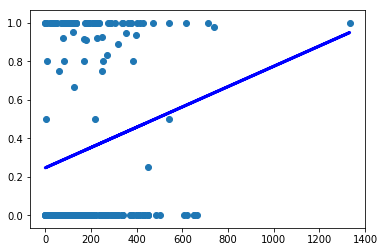

In [0]:
lm = LinearRegression()
X = added_ratios['Less than $15,000']
X = np.array(list(X)).reshape(-1, 1)
y = added_ratios['RATIO UNHEALTHY'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
# linear regression of ratio of unhealthy to number of people in the lowest bracket
plt.plot(X_test, prediction, color='blue', linewidth=3)

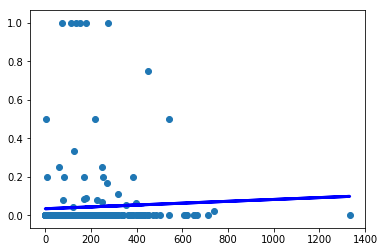

In [0]:
X = added_ratios['Less than $15,000']
X = np.array(list(X)).reshape(-1, 1)
y = added_ratios['RATIO HEALTHY'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
# linear regression of ratio of healthy to number of people in the lowest bracket
plt.plot(X_test, prediction, color='blue', linewidth=3)

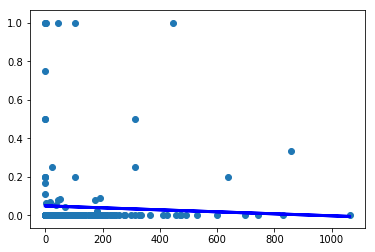

In [0]:
lm = LinearRegression()
X = added_ratios['$200,000 or more']
X = np.array(list(X)).reshape(-1, 1)
y = added_ratios['RATIO HEALTHY'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
# linear regression of ratio of healthy to number of people in the highest bracket
plt.plot(X_test, prediction, color='blue', linewidth=3)

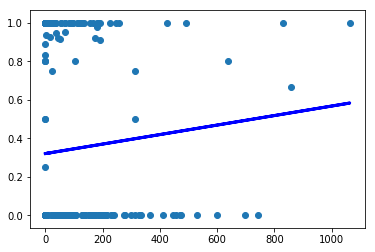

In [0]:
lm = LinearRegression()
X = added_ratios['$200,000 or more']
X = np.array(list(X)).reshape(-1, 1)
y = added_ratios['RATIO UNHEALTHY'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
# linear regression of ratio of unhealthy to number of people in the highest bracket
plt.plot(X_test, prediction, color='blue', linewidth=3)

PART 6

Generate a map showing the ratio of healthy and not healthy food options, and the locations of stores offering healthy food options.

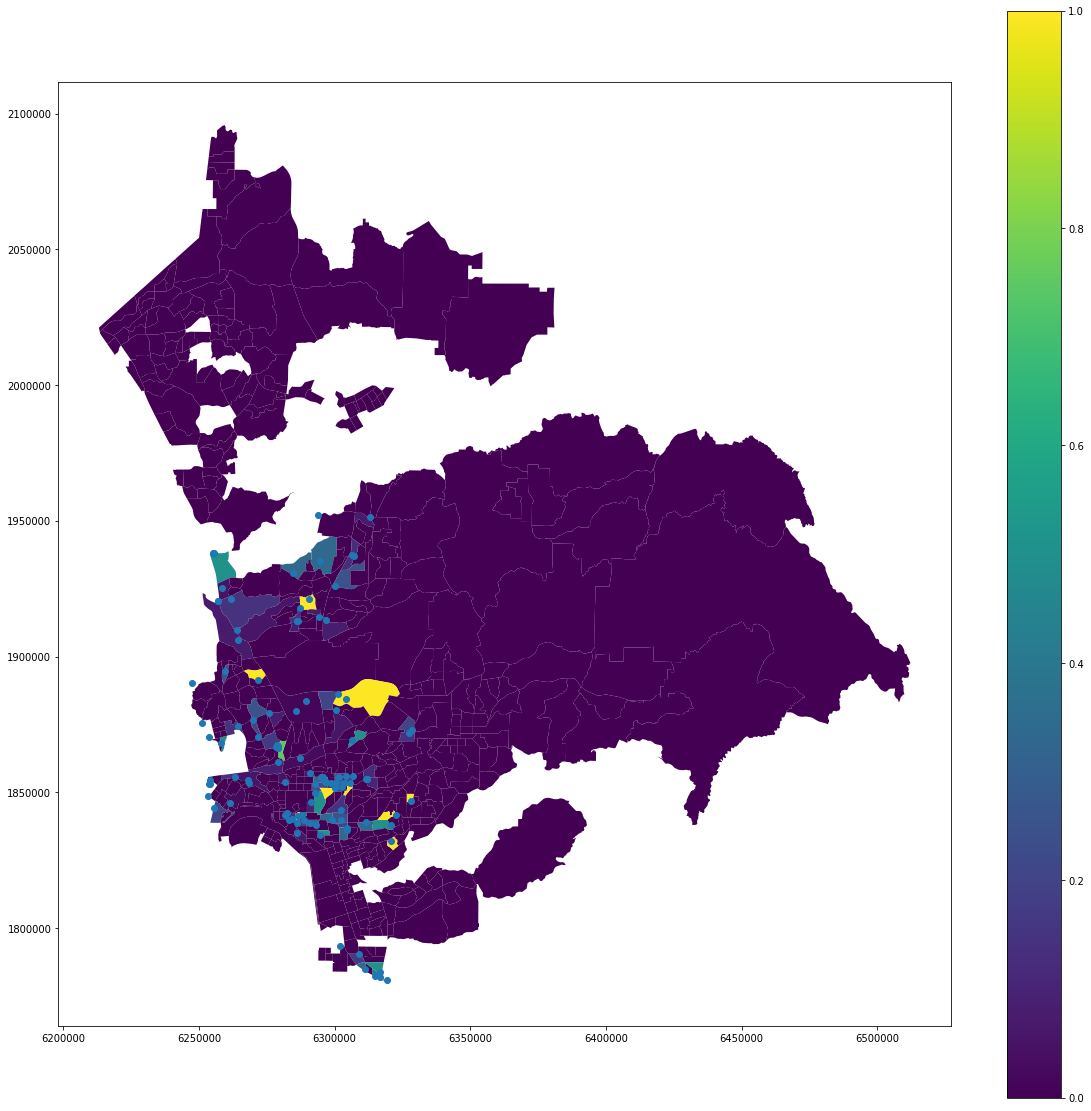

In [0]:
fig, ax = plt.subplots(figsize=(20, 20))
added_ratios.plot(column = 'RATIO HEALTHY', legend = True,ax=ax) # choropleth of the ratio of healthy 
healthy_stores.plot(ax=ax) # location of the stores 

__Results of linear regression:__

The different linear regressions tell us an interesting story that confirms our initial belief. Our first linear regression (unhealthy food, lowest bracket) shows a high correlation. The larger the number of people in the lower bracket, the higher the ratio of unhealthy food. The second linear regression (healthy food, lowest bracket) tells a much worse story, where the ratio of healthy food is relatively low throughout (and remains stagnant as the amount of people in the lower bracket increases). For our third linear regression (healthy food, highest bracket), the ratio of unhealthy food actually decreases as the numer of people in the highest bracket increases. This is the only time a ratio decreases as population increases. In our last linear regression (unhealthy food, highest bracket), the ratio increases, although not as nearly as strong as the lowest bracket.